## Decision Trees

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
# from xgboost import XGBClassifier

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from numeric import get_numeric_df
from sklearn import tree

In [2]:
original_df = pd.read_csv("..\\Dataset\\preprocessed_data\\fraud_oracle_preprocessed_drop.csv")
df = get_numeric_df(original_df)
df.head()


,Month,WeekOfMonth,DayOfWeek,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,Age,Fault,...,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,11,5,2,0,1,0,1,0,21.0,1,...,0,0,1,0,0,1,0,0,0,1
1,0,3,2,0,0,0,4,1,34.0,1,...,0,0,1,0,0,1,0,0,1,0
2,9,5,4,0,3,10,2,1,47.0,1,...,0,1,0,0,0,1,0,0,1,0
3,5,2,5,0,4,6,1,1,65.0,0,...,0,1,0,0,0,1,0,0,0,1
4,0,5,0,0,1,1,2,0,27.0,0,...,0,0,1,0,0,1,0,0,1,0


In [5]:
print(len(df.columns))

56


In [6]:
def get_stats(classifier, X, Y, k = 10):
    out = dict()
    res = cross_validate(clf_DTmodel, X, Y, cv=k, scoring=['accuracy', 'precision','recall'])
    for score in res:
        out[score] = np.mean(res[score])
    return out


In [25]:
# X, Y -> explanatory/resopnse variable split
X = df.drop('FraudFound_P',axis=1).copy()
Y = df['FraudFound_P'].copy()

### Basic Decision Tree

In [8]:
# Basic DT
clf_DTmodel = DecisionTreeClassifier(random_state=0)
results = get_stats(clf_DTmodel, X, Y)
for r in results:
    print(f'{r}: {results[r]}')

fit_time: 0.1308499574661255
score_time: 0.006885170936584473
test_accuracy: 0.8944814920491435
test_precision: 0.1286322804969547
test_recall: 0.13114773258532023


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


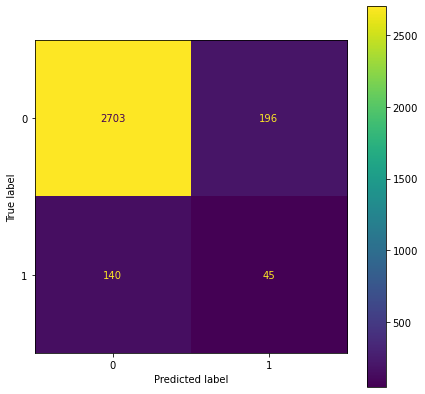

In [26]:
x_train,x_test,y_train,y_test = train_test_split(X, Y, stratify=Y,test_size = 0.2, random_state=0)
clf_DTmodel.fit(x_train,y_train)
y_pred_gini_unpruned = clf_DTmodel.predict(x_test)

fig, (ax1) = plt.subplots(figsize=(7, 7))
metrics.plot_confusion_matrix(clf_DTmodel, x_test, y_test, ax=ax1)

In [175]:
# different depth
accuracy = []
precision = []
recall = []
for d in range(1,21):
    clf_DTmodel = DecisionTreeClassifier(random_state=42, max_depth=d)
    results = get_stats(clf_DTmodel, X, Y)
    precision.append(results['test_precision'])
    recall.append(results['test_recall'])
    accuracy.append(results['test_accuracy'])

x = range(1,21)

figure, axis = plt.subplots(1, 3, figsize=(25,5))
axis[0].plot(x, accuracy, marker='o')
axis[0].set_title("Accuracy")

axis[1].plot(x, precision, marker='o')
axis[1].set_title("Precision")

axis[2].plot(x, recall, marker='o')
axis[2].set_title("Recall")

In [177]:
accuracy = []
precision = []
recall = []
# ccp_alpha
cc = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for c in cc:
    clf_DTmodel = DecisionTreeClassifier(random_state=42, ccp_alpha = c)
    results = get_stats(clf_DTmodel, X, Y)
    precision.append(results['test_precision'])
    recall.append(results['test_recall'])
    accuracy.append(results['test_accuracy'])

figure, axis = plt.subplots(1, 3, figsize=(25,5))
axis[0].plot(cc, accuracy, marker='o')
axis[0].set_title("Accuracy")

axis[1].plot(cc, precision, marker='o')
axis[1].set_title("Precision")

axis[2].plot(cc, recall, marker='o')
axis[2].set_title("Recall")

In [63]:
# Compare different pruning levels
ccp_alphas = [0.2, 0.4, 0.5, 0.8]
for a in ccp_alphas:
    print(f'CCP alpha: {a}')
    results = get_stats(clf_DTmodel, X, Y)
    for r in results:
        print(f'{r}: {results[r]}')
    print()

CCP alpha: 0.2
fit_time: 0.10023105144500732
score_time: 0.014362716674804687
test_accuracy: 0.8944814920491435
test_balanced_accuracy: 0.537118593928842
test_precision: 0.1286322804969547
test_recall: 0.13114773258532023
test_roc_auc: 0.5371185939288421

CCP alpha: 0.4
fit_time: 0.0957535982131958
score_time: 0.00966796875
test_accuracy: 0.8944814920491435
test_balanced_accuracy: 0.537118593928842
test_precision: 0.1286322804969547
test_recall: 0.13114773258532023
test_roc_auc: 0.5371185939288421

CCP alpha: 0.5
fit_time: 0.09784152507781982
score_time: 0.010267281532287597
test_accuracy: 0.8944814920491435
test_balanced_accuracy: 0.537118593928842
test_precision: 0.1286322804969547
test_recall: 0.13114773258532023
test_roc_auc: 0.5371185939288421

CCP alpha: 0.8
fit_time: 0.09784810543060303
score_time: 0.01026294231414795
test_accuracy: 0.8944814920491435
test_balanced_accuracy: 0.537118593928842
test_precision: 0.1286322804969547
test_recall: 0.13114773258532023
test_roc_auc: 0.537

### Other classifiers

### Oversampling

In [27]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

In [28]:
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
# X_res, Y_res = sm.fit_resample(X, Y)
print(y_train.value_counts())
print(y_train_res.value_counts())

0    11597
1      738
Name: FraudFound_P, dtype: int64
1    11597
0    11597
Name: FraudFound_P, dtype: int64


In [56]:
clf_DTmodel = DecisionTreeClassifier(random_state=0)
results = get_stats(clf_DTmodel, x_train_res, y_train_res)
for r in results:
    print(f'{r}: {results[r]}')

fit_time: 0.14478724002838134
score_time: 0.005928254127502442
test_accuracy: 0.9377484349675097
test_precision: 0.9294471413522836
test_recall: 0.9476711493261133


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


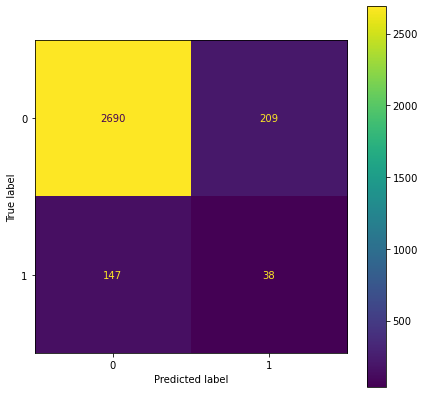

In [57]:
# x_train_res,x_test_res,y_train_res,y_test_res = train_test_split(X_res, Y_res, stratify=Y_res,test_size = 0.2, random_state=0)
clf_DTmodel.fit(x_train_res,y_train_res)
# y_pred_gini_unpruned = clf_DTmodel.predict(x_test)

fig, (ax1) = plt.subplots(figsize=(7, 7))
metrics.plot_confusion_matrix(clf_DTmodel, x_test, y_test, ax=ax1)